In [1]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import activations
from tensorflow.keras.applications import EfficientNetB0

import os
import math
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf


os.environ['CUDA_VISIBLE_DEVICES'] = '1'

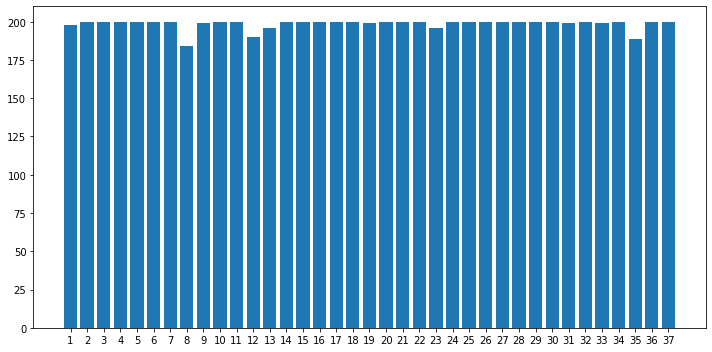

In [2]:
#Image CLASS-ID SPECIES BREED ID
#ID: 1:37 Class ids
#SPECIES: 1:Cat 2:Dog
#BREED ID: 1-25:Dog 1:12:Cat
#All images with 1st letter as captial are cat images
#images with small first letter are dog images

csv_path = 'data/kfolds.csv'
df = pd.read_csv(csv_path)
np.unique(df['id'])

value_counts = df['id'].value_counts().sort_index()
plt.figure(figsize=(10,5))
plt.bar(range(len(value_counts)), value_counts.values)
plt.xticks(range(len(value_counts)), value_counts.index.values)
plt.tight_layout()
plt.show()

In [3]:
def get_model(input_shape):
    inputs = keras.Input(input_shape)
    base_model = EfficientNetB0(
        input_shape = input_shape,
        weights='imagenet',
        include_top=False,
        pooling='avg'
    )
    
    x = base_model(inputs)
    output = layers.Dense(37, activation='softmax')(x)
    model = keras.Model(inputs, output)
    
    return model


input_shape = (256,256, 3)
model = get_model(input_shape)

adam = keras.optimizers.Adam(lr = 0.0001)
model.compile(
    optimizer = adam,
    loss = 'sparse_categorical_crossentropy',
    metrics = 'accuracy'
)


model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb0 (Functional)  (None, 1280)             4049571   
                                                                 
 dense (Dense)               (None, 37)                47397     
                                                                 
Total params: 4,096,968
Trainable params: 4,054,945
Non-trainable params: 42,023
_________________________________________________________________


C:\Users\khj_a\AppData\Local\Programs\Python\Python38\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [4]:
import albumentations as A

class Augmentation:
    def __init__(self, size, mode='train'):
        if mode == 'train':
            self.transform = A.Compose([
                A.HorizontalFlip(p=0.5),
                A.ShiftScaleRotate(
                    p=0.5,
                    shift_limit=0.05,
                    scale_limit=0.05,
                    rotate_limit=15,
                ),
                A.CoarseDropout(
                    p=0.5,
                    max_holes=8,
                    max_height=int(0.1 * size),
                    max_width=int(0.1* size)
                ),
                A.RandomBrightnessContrast(p=0.2),
            ])
    def __call__(self, **kwargs):
        if self.transform:
            augmented = self.transform(**kwargs)
            img = augmented['image']
            return img

In [5]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, image_size,
                 fold, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.fold = fold
        self.mode = mode
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        #### Remove invalid files
        #### https://github.com/tensorflow/models/issues/3134
        invalid_filenames = [
            'Egyptian_Mau_14',
            'Egyptian_Mau_139',
            'Egyptian_Mau_145',
            'Egyptian_Mau_156',
            'Egyptian_Mau_167',
            'Egyptian_Mau_177',
            'Egyptian_Mau_186',
            'Egyptian_Mau_191',
            'Abyssinian_5',
            'Abyssinian_34',
            'chihuahua_121',
            'beagle_116'
        ]
        self.df = self.df[~self.df['file_name']. \
                          isin(invalid_filenames)]
        self.transform = Augmentation(image_size, mode)
        
        self.on_epoch_end()
            
    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)
        
    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        
        batch_x, batch_y = self.get_data(data)
        
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            
            image = cv2.resize(image, (self.image_size, self.image_size))
            
            if self.mode == 'train':
                image = image.astype('uint8')
                image = self.transform(image=image)
            
            image = image.astype('float32')
            image = image / 255.
            
            label = int(r['id']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

In [6]:
csv_path = 'data/kfolds.csv'
train_generator = DataGenerator(
    fold=1,
    mode='train',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

valid_generator = DataGenerator(
    fold=1,
    mode='val',
    csv_path=csv_path,
    batch_size=128,
    image_size=256,
    shuffle=True)

In [13]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    verbose=1
)


Epoch 1/10


In [1]:
import matplotlib.pyplot as plt
history = history.history

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='train')
plt.plot(history['val_loss'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title("Loss")


plt.subplot(1, 2, 2)
plt.plot(history['accuracy'], label='train')
plt.plot(history['val_accuracy'], label='val')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title("Accuracy")
plt.show()


NameError: name 'history' is not defined